# Evaluation

## Init

In [1]:
# general imports:
import os
import importlib
from torch import nn, cuda
from torch import optim
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

# my imports (reload all modules):

from data.dataset import load_data_deep_crack
from models.unet_resnet34 import UNetResNet34
from models.unet_swin import UNetSwin
from models.unet import UNet
from training.metrics import DiceLoss
from training.metrics import evaluate_dice_index
from training.train import train
from utils import count_trainable_parameters
from utils import to_4_significant_digits
from utils import generate_latex_table_thesis
from plotting import plot_image_mask_prediction_grid


import data.dataset
import models.unet_resnet34
import models.unet_swin
import models.unet
import training.metrics
import training.train
import utils
import plotting

importlib.reload(data.dataset)
importlib.reload(models.unet_resnet34)
importlib.reload(models.unet_swin)
importlib.reload(models.unet)
importlib.reload(training.metrics)
importlib.reload(training.train)
importlib.reload(utils)
importlib.reload(plotting)

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
print(f'Number of visible CUDA devices: {cuda.device_count()}')
cuda.is_available()
# NOTE: when referring to a CUDA device, torch will only know about visible devices
#       so while currently we will be using gpu05
#       this will be device `cuda:0`

# LOAD THE DATA
data_source ='../../DeepCrack/dataset/DeepCrack'
train_image_dir = data_source + '/train_img'
train_mask_dir = data_source + '/train_lab'
test_image_dir = data_source + '/test_img'
test_mask_dir = data_source + '/test_lab'
train_dl, val_dl, train_dataset, val_dataset = load_data_deep_crack(train_image_dir, train_mask_dir, [0.8, 0.2], limit_im_nr=10)
# use validation to avoid augmentation
_, test_dl, _, test_dataset = load_data_deep_crack(test_image_dir, test_mask_dir, [0, 1])

c:\Users\Csaba\miniconda3\envs\cenv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Csaba\miniconda3\envs\cenv2\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Number of visible CUDA devices: 1
This gives us 240 train and 60 validation samples.
This gives us 0 train and 237 validation samples.


c:\Users\Csaba\miniconda3\envs\cenv2\Lib\site-packages\torch\utils\data\dataset.py:473: UserWarning: Length of split at index 0 is 0. This might result in an empty dataset.
  warnings.warn(


## UNET

## UNET all

In [ ]:
import numpy as np
import torch
from tqdm import tqdm

# List of model subdirectories
path_list = ['unet_0', 'unet_1', 'unet_2', 'unet_3', 'unet_4', 'unet_5']
learning_rates = [ "1e-4 - 5e-4", "1e-3","1e-3","1e-3","1e-3","1e-3"]
started_from_models = [ "none", "none", "none", "none", "none","none"]
names = [ "unet-0", "unet-1", "unet-2", "unet-3", "unet-4","unet-5"]
epochs = [238, 166, 100,100,100,100]
#path_list = ['unet_6']

# Corresponding model parameter sets
param_sets = [
    {'img_channels': 3, 'mask_channels': 1, 'base_channel_size': 64, 'depth': 5},
    {'img_channels': 3, 'mask_channels': 1, 'base_channel_size': 64, 'depth': 5},
    {'img_channels': 3, 'mask_channels': 1, 'base_channel_size': 64, 'depth': 4},
    {'img_channels': 3, 'mask_channels': 1, 'base_channel_size': 64, 'depth': 3},
    {'img_channels': 3, 'mask_channels': 1, 'base_channel_size': 32, 'depth': 5},
    {'img_channels': 3, 'mask_channels': 1, 'base_channel_size': 16, 'depth': 5},
]

# A list to store all evaluation results for later processing
results = []

# Iterate through all models and evaluate
for idx, (param, path) in enumerate(zip(param_sets, path_list), 1):
    print(f"\nProcessing model: {idx}/{len(path_list)} ({path})")

    # Initialize model and loss function
    model = UNet(**param)
    loss_fn = DiceLoss()

    # Load model training statistics
    model_dir = f'../saved_models/{path}'
    dice_idcs = list(np.load(f'{model_dir}/dice_idcs.npy'))
    epoch_dice_idcs = list(np.load(f'{model_dir}/epoch_dice_idcs.npy'))
    val_dice_idcs = list(np.load(f'{model_dir}/val_dice_idcs.npy'))
    train_loss = list(np.load(f'{model_dir}/train_loss.npy'))
    val_loss = list(np.load(f'{model_dir}/val_loss.npy'))
    epoch_durations = list(np.load(f'{model_dir}/epoch_durations.npy'))

    # Load best weights
    model.load_state_dict(torch.load(f'{model_dir}/best_model_wts.pth', weights_only=True))
    model.eval().cuda()

    # Evaluate on test set
    avg_score, score_list, preds = evaluate_dice_index(model, test_dataset)

    # Store everything in a dictionary
    result_entry = {
        "name": names[idx-1],
        "params": param,
        "dice_idcs": dice_idcs,
        "epoch_dice_idcs": epoch_dice_idcs,
        "val_dice_idcs": val_dice_idcs,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "epoch_durations" :epoch_durations,
        "test_avg_dice": avg_score,
        "test_dice_scores": score_list,
        "test_predictions": preds,
        "number_of_params": count_trainable_parameters(model),
        "epoch_nr": epochs[idx-1],
        "lr": learning_rates[idx-1],
        "started_from": started_from_models[idx-1]
    }

    # Append results
    results.append(result_entry)

print("\nAll models processed.")



Processing model: 1/6 (unet_0)


c:\Users\Csaba\miniconda3\envs\cenv2\Lib\site-packages\torch\nn\modules\conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return F.conv2d(



Processing model: 2/6 (unet_1_total)

Processing model: 3/6 (unet_2)

Processing model: 4/6 (unet_3)

Processing model: 5/6 (unet_4)

Processing model: 6/6 (unet_5)

All models processed.


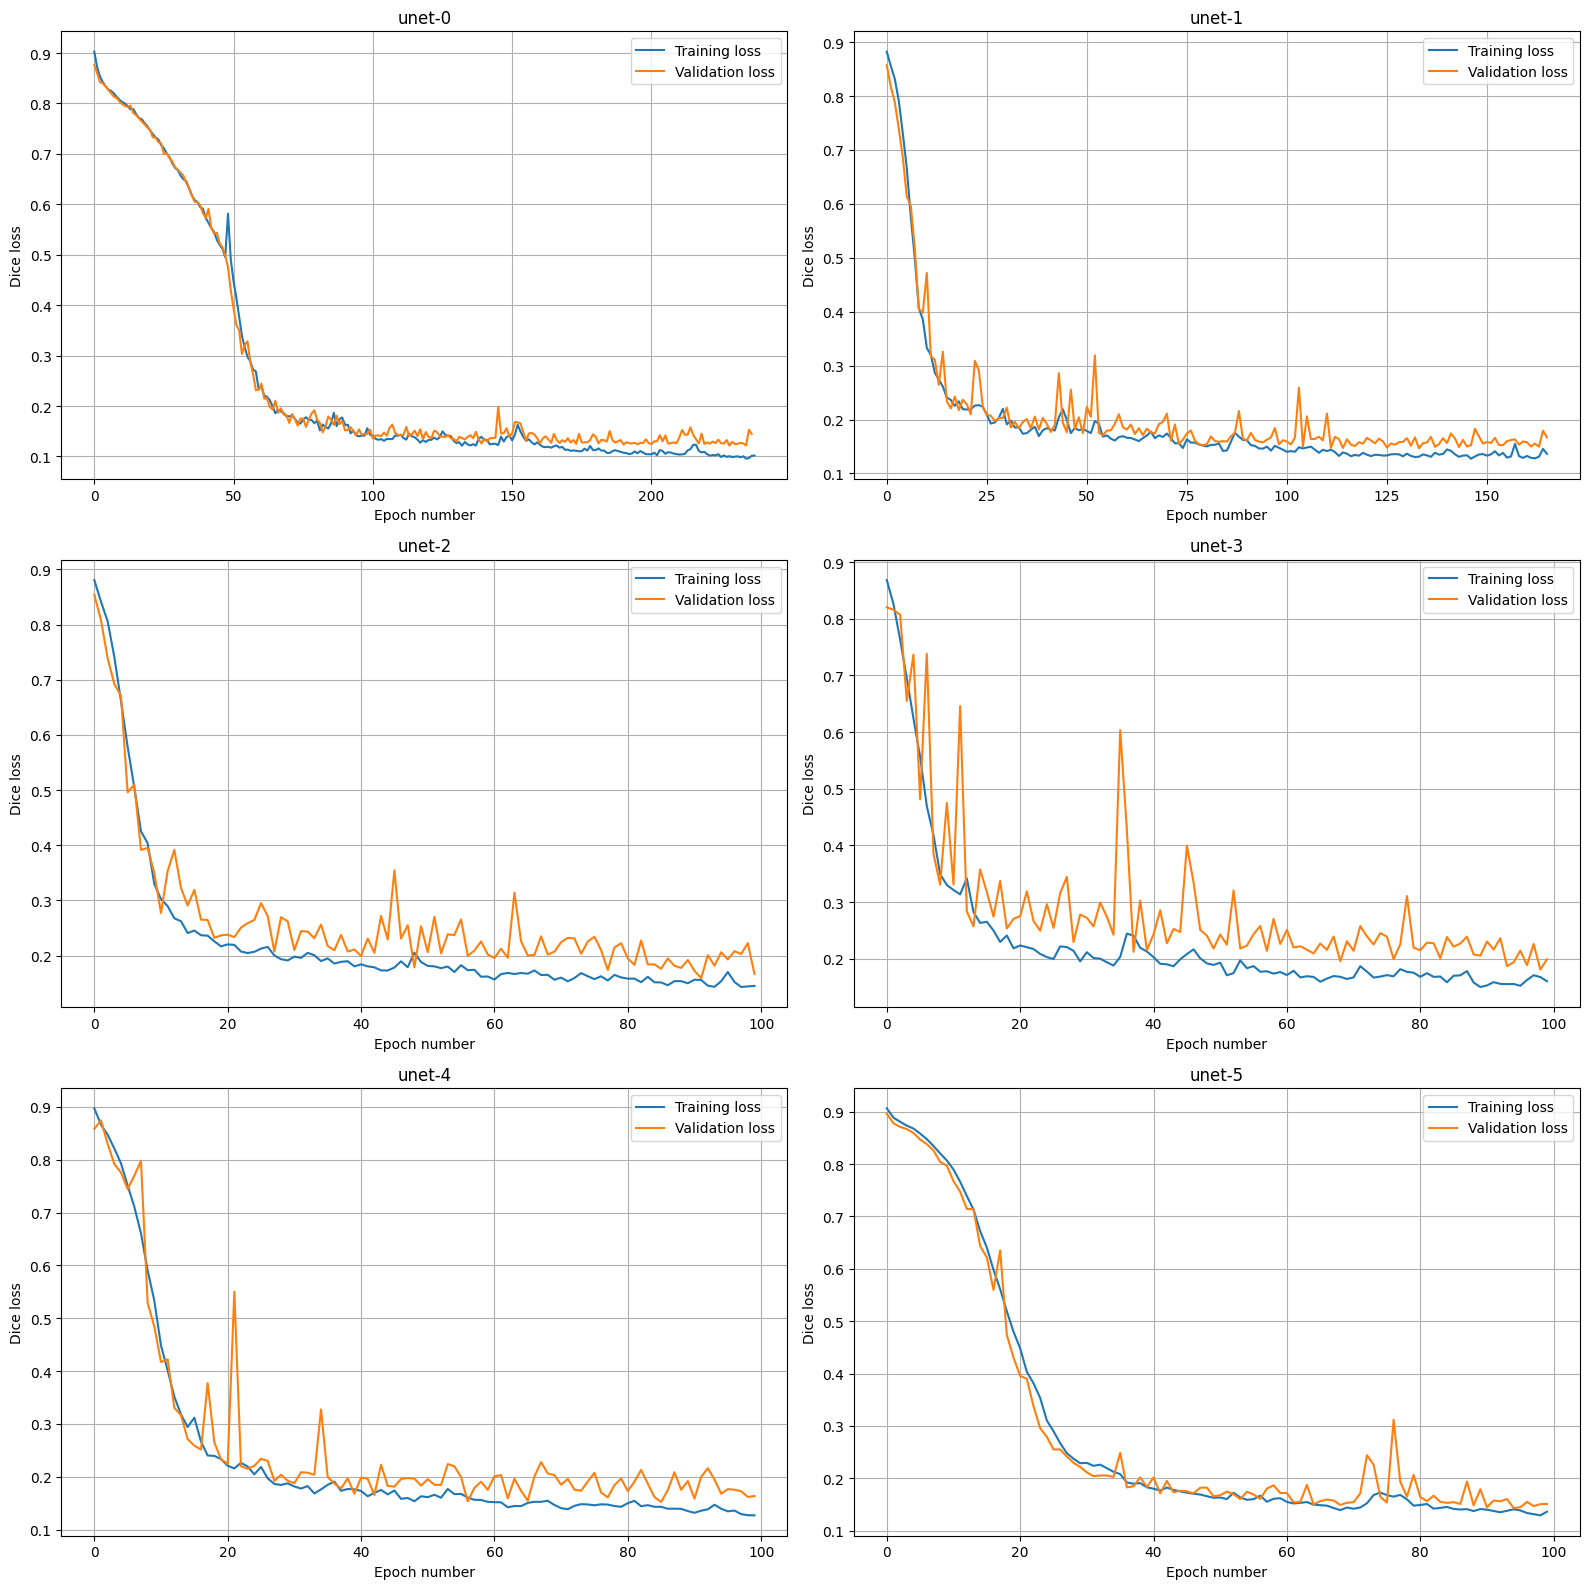

In [3]:
# Set up the subplot grid
fig, axs = plt.subplots(3, 2, figsize=(16, 16))
axs = axs.flatten()  # Flatten the 2D grid into 1D for easier indexing

# Plot each model's loss curves
for i, res in enumerate(results):
    ax = axs[i]
    
    # Plot training and validation loss
    ax.plot(res["train_loss"], label='Training loss')
    ax.plot(res["val_loss"], label='Validation loss')
    
    ax.set_title(res["name"])
    ax.set_xlabel("Epoch number")
    ax.set_ylabel("Dice loss")
    ax.grid(True)
    ax.legend()


plt.tight_layout()
plt.savefig("../outputs/generated_figures/unet_losses.png", dpi=300, bbox_inches='tight')
#plt.show()

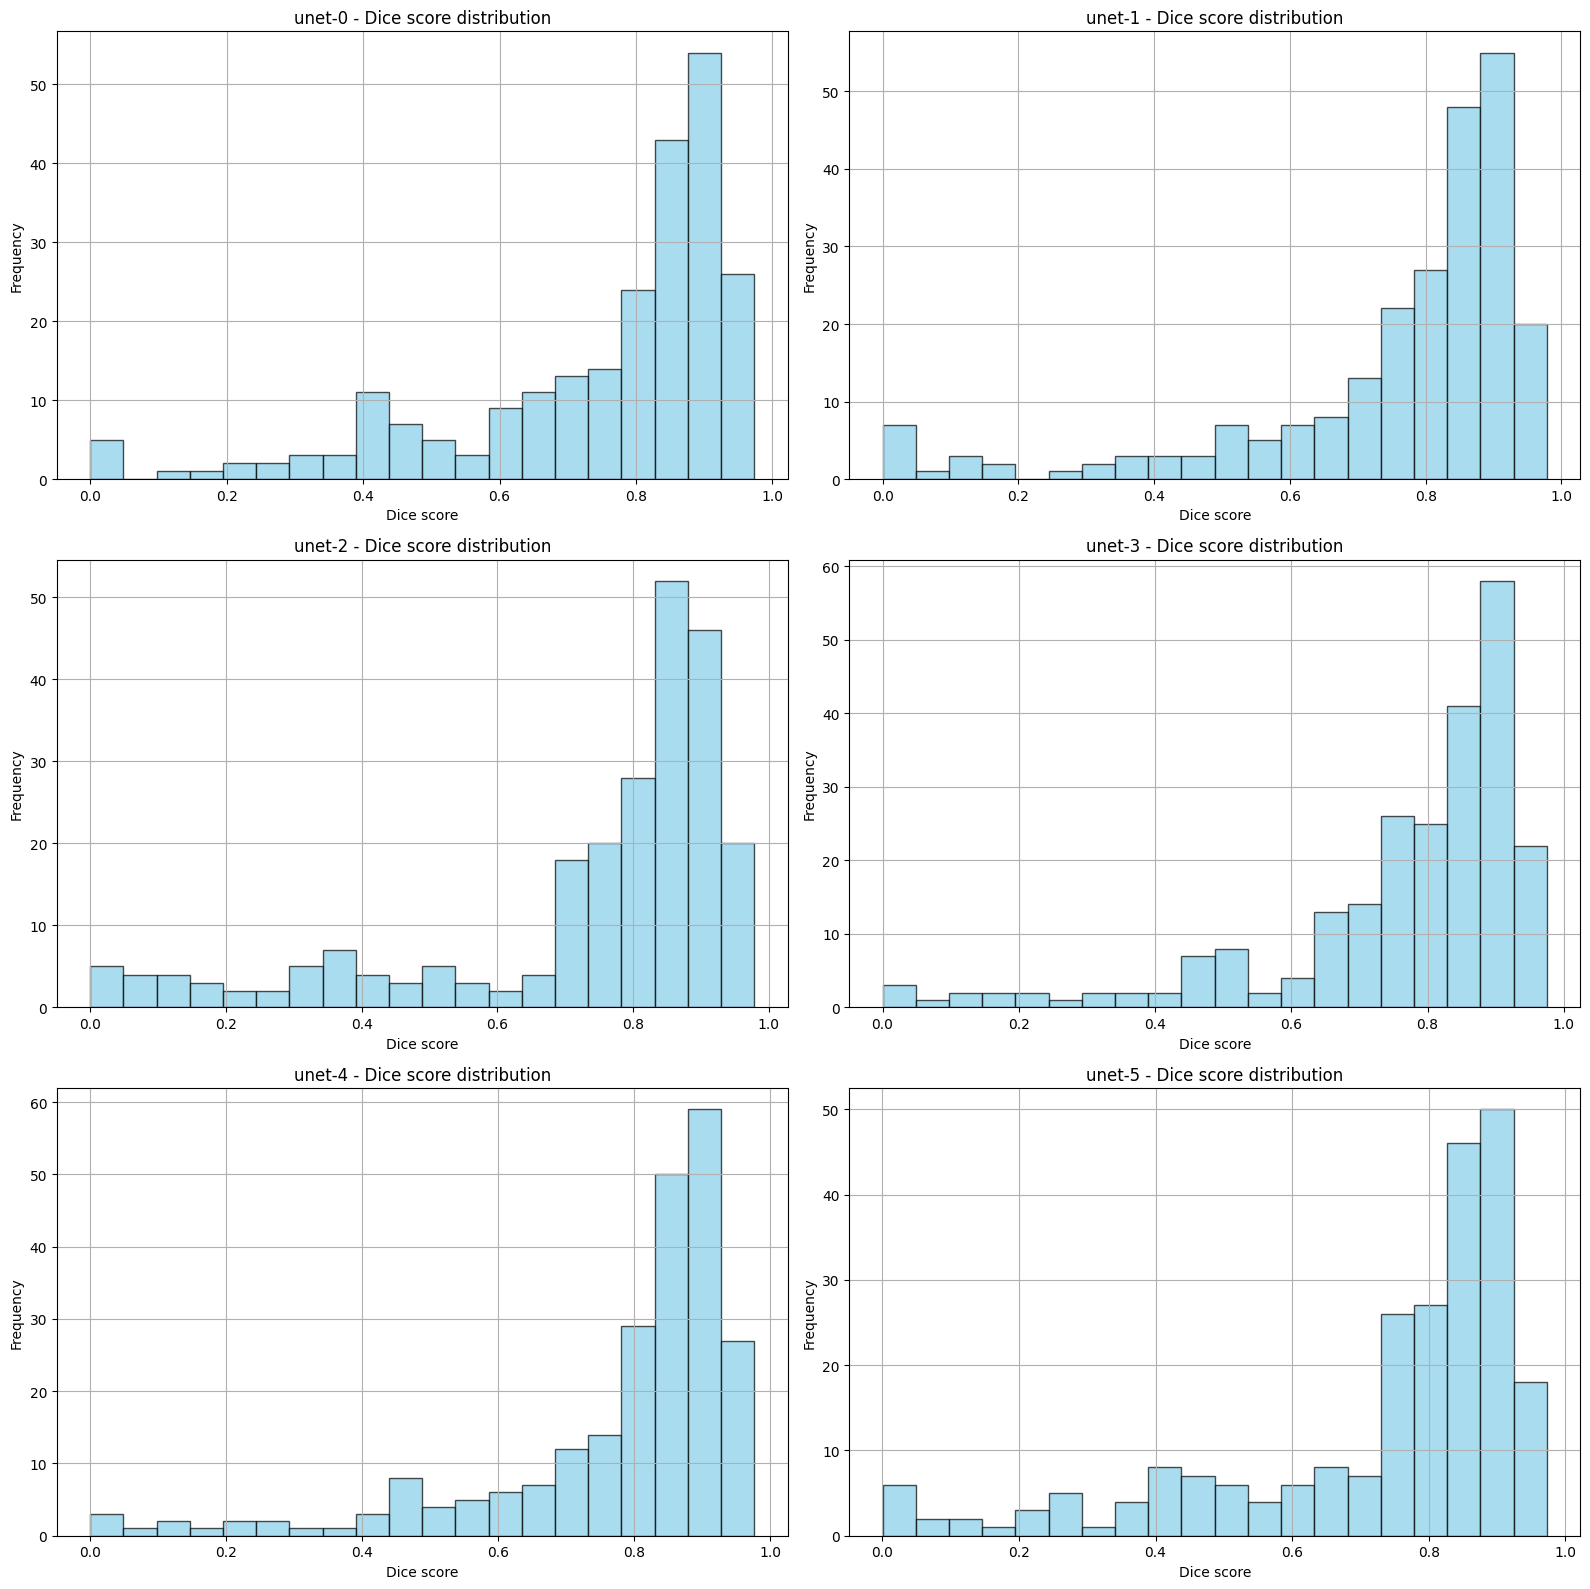

In [4]:
import matplotlib.pyplot as plt

# Set up the 2x2 subplot grid
fig, axs = plt.subplots(3, 2, figsize=(16, 16))
axs = axs.flatten()

# Plot histograms for the first 4 models
for i in range(6):
    res = results[i]
    ax = axs[i]
    
    ax.hist(res['test_dice_scores'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax.set_title(f"{res['name']} - Dice score distribution")
    ax.set_xlabel("Dice score")
    ax.set_ylabel("Frequency")
    ax.grid(True)

plt.tight_layout()
plt.savefig("../outputs/generated_figures/unet_dice_dist.png", dpi=300, bbox_inches='tight')
#plt.show()


In [5]:
# Build a list of dictionaries with desired summary information
summary_data = []
#learning_rates = [ "0.0001-0.0005", "0.001", "0.001", "0.001", "0.001","0.001"]
for res in results:
    summary_data.append({
        "Name": res["name"],
        "Learn. rate": res["lr"],  # Adjust if you stored learning rate elsewhere
        "Depth": res["params"].get("depth"),
        "Channel nr.": res["params"].get("base_channel_size"),
        "Epochs": res["epoch_nr"],
        "Million parameters": to_4_significant_digits(res["number_of_params"]/1000000),
        "Started from": res["started_from"]
    })

# Create DataFrame
summary_df = pd.DataFrame(summary_data)
generate_latex_table_thesis(summary_df, '../outputs/tables/unet_summary.tex')
# Display the DataFrame
print(summary_df)

     Name  Learn. rate  Depth  Channel nr.  Epochs Million parameters  \
0  unet-0  1e-4 - 5e-4      5           64     238              31.04   
1  unet-1         1e-3      5           64     166              31.04   
2  unet-2         1e-3      4           64     100              7.703   
3  unet-3         1e-3      3           64     100              1.865   
4  unet-4         1e-3      5           32     100              7.766   
5  unet-5         1e-3      5           16     100              1.944   

  Started from  
0         none  
1         none  
2         none  
3         none  
4         none  
5         none  


In [6]:
# Prepare summary data
summary_data = []

for res in results:
    # Compute training time in hours
    total_seconds = sum(res.get("epoch_durations", []))
    training_time_hours = round(total_seconds / 3600, 3)

    # Build the row dictionary
    summary_data.append({
        "Name": res["name"],
        "Average Dice index": round(res["test_avg_dice"], 3),
        "Training time [hours]": training_time_hours
    })

# Create DataFrame
summary_df = pd.DataFrame(summary_data)
generate_latex_table_thesis(summary_df, '../outputs/tables/unet_results.tex')
# Display the result
print(summary_df)

     Name  Average Dice index  Training time [hours]
0  unet-0               0.747                  0.000
1  unet-1               0.757                 33.249
2  unet-2               0.732                 12.858
3  unet-3               0.763                  9.146
4  unet-4               0.780                  2.213
5  unet-5               0.729                  0.951


In [ ]:
# List of model subdirectories
path_list = ['unet_4_lr1e-2', 'unet_4_lr2e-4']
learning_rates = [ "1e-2", "2e-4"]
started_from_models = [ "none", "unet-4"]
names = [ "unet-4-1", "unet-4-2"]
epochs = [100, 300]
#path_list = ['unet_6']

# Corresponding model parameter sets
param_sets = [
    {'img_channels': 3, 'mask_channels': 1, 'base_channel_size': 32, 'depth': 5},
    {'img_channels': 3, 'mask_channels': 1, 'base_channel_size': 32, 'depth': 5}
]

# A list to store all evaluation results for later processing
results_unet4 = []

# Iterate through all models and evaluate
for idx, (param, path) in enumerate(zip(param_sets, path_list), 1):
    print(f"\nProcessing model: {idx}/{len(path_list)} ({path})")

    # Initialize model and loss function
    model = UNet(**param)
    loss_fn = DiceLoss()

    # Load model training statistics
    model_dir = f'../saved_models/{path}'
    dice_idcs = list(np.load(f'{model_dir}/dice_idcs.npy'))
    epoch_dice_idcs = list(np.load(f'{model_dir}/epoch_dice_idcs.npy'))
    val_dice_idcs = list(np.load(f'{model_dir}/val_dice_idcs.npy'))
    train_loss = list(np.load(f'{model_dir}/train_loss.npy'))
    val_loss = list(np.load(f'{model_dir}/val_loss.npy'))
    epoch_durations = list(np.load(f'{model_dir}/epoch_durations.npy'))

    # Load best weights
    model.load_state_dict(torch.load(f'{model_dir}/best_model_wts.pth', weights_only=True))
    model.eval().cuda()

    # Evaluate on test set
    avg_score, score_list, preds = evaluate_dice_index(model, test_dataset)

    # Store everything in a dictionary
    result_entry = {
        "name": names[idx-1],
        "params": param,
        "dice_idcs": dice_idcs,
        "epoch_dice_idcs": epoch_dice_idcs,
        "val_dice_idcs": val_dice_idcs,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "epoch_durations" :epoch_durations,
        "test_avg_dice": avg_score,
        "test_dice_scores": score_list,
        "test_predictions": preds,
        "number_of_params": count_trainable_parameters(model),
        "epoch_nr": epochs[idx-1],
        "lr": learning_rates[idx-1],
        "started_from": started_from_models[idx-1]
    }

    # Append results
    results_unet4.append(result_entry)

print("\nAll models processed.")



Processing model: 1/2 (unet_4_lr1e-2)

Processing model: 2/2 (unet_4_lr2e-4)

All models processed.


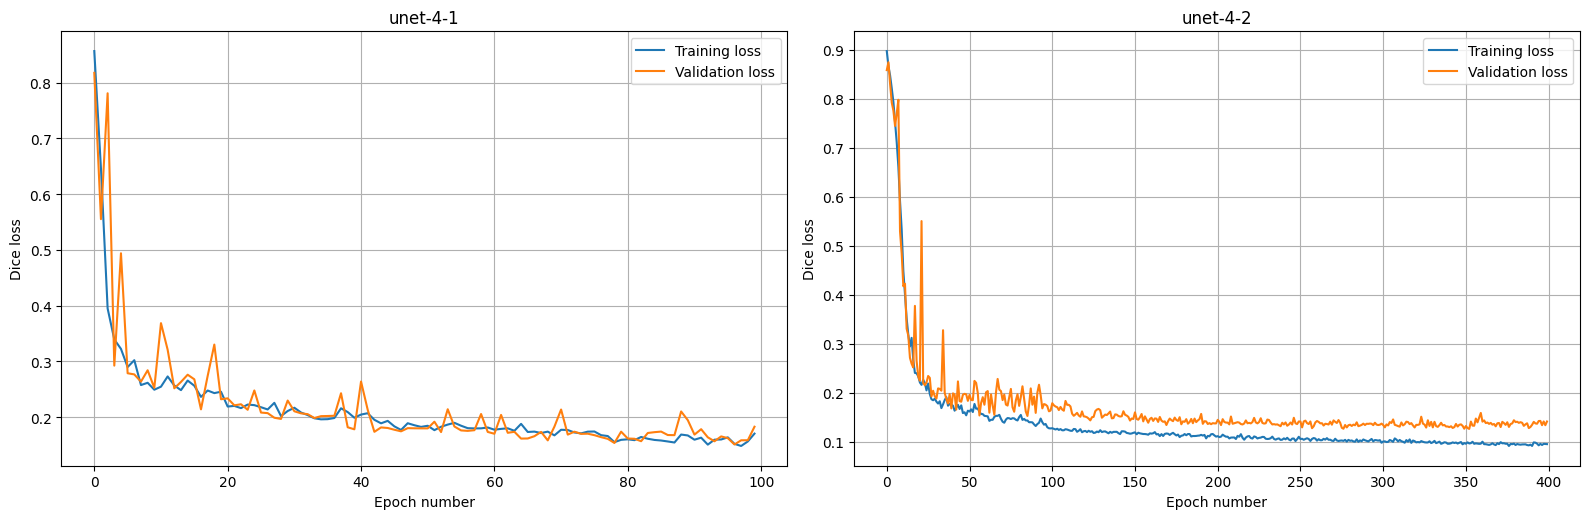

In [8]:
# Set up the subplot grid
fig, axs = plt.subplots(1, 2, figsize=(16, 5.3))
axs = axs.flatten()  # Flatten the 2D grid into 1D for easier indexing

# Plot each model's loss curves
for i, res in enumerate(results_unet4):
    ax = axs[i]
    
    # Plot training and validation loss
    ax.plot(res["train_loss"], label='Training loss')
    ax.plot(res["val_loss"], label='Validation loss')
    
    ax.set_title(res["name"])
    ax.set_xlabel("Epoch number")
    ax.set_ylabel("Dice loss")
    ax.grid(True)
    ax.legend()


plt.tight_layout()
plt.savefig("../outputs/generated_figures/unet4_losses.png", dpi=300, bbox_inches='tight')
plt.show()

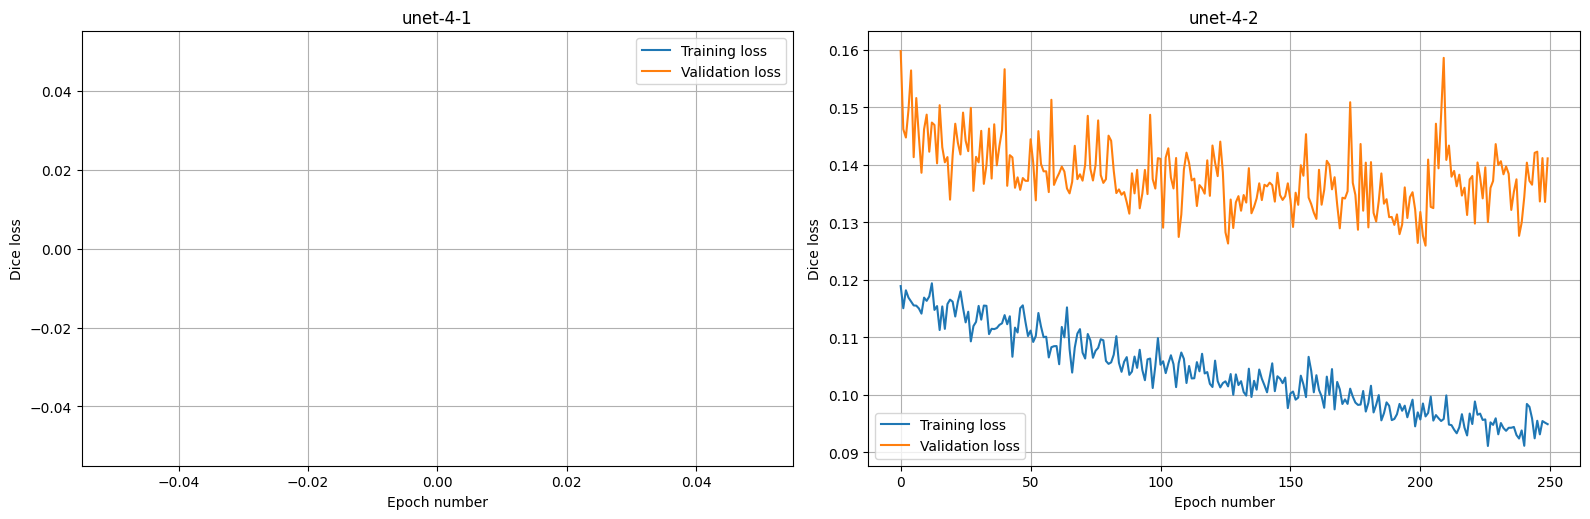

In [9]:
# Set up the subplot grid
fig, axs = plt.subplots(1, 2, figsize=(16, 5.3))
axs = axs.flatten()  # Flatten the 2D grid into 1D for easier indexing

# Plot each model's loss curves
for i, res in enumerate(results_unet4):
    ax = axs[i]
    train_loss = res["train_loss"]
    val_loss = res["val_loss"]
    # Plot training and validation loss
    ax.plot(train_loss[150:], label='Training loss')
    ax.plot(val_loss[150:], label='Validation loss')
    
    ax.set_title(res["name"])
    ax.set_xlabel("Epoch number")
    ax.set_ylabel("Dice loss")
    ax.grid(True)
    ax.legend()


plt.tight_layout()
plt.savefig("../outputs/generated_figures/unet4_losses_detailed.png", dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# Sort the scores and keep track of original indices
sorted_pairs = sorted(enumerate(val_loss), key=lambda x: x[1])

# Extract the sorted scores and their original indices
sorted_scores = [score for idx, score in sorted_pairs]
original_indices = [idx for idx, score in sorted_pairs]
print(original_indices)

[352, 276, 349, 257, 388, 351, 342, 275, 326, 319, 278, 251, 330, 301, 340, 343, 371, 389, 376, 333, 310, 345, 338, 339, 368, 258, 341, 238, 285, 332, 309, 350, 281, 328, 385, 348, 242, 355, 286, 354, 264, 303, 318, 312, 308, 336, 283, 279, 237, 398, 294, 396, 334, 202, 289, 297, 300, 169, 277, 337, 321, 374, 287, 320, 307, 346, 390, 298, 280, 269, 366, 296, 282, 325, 235, 245, 243, 267, 215, 240, 233, 302, 347, 236, 207, 386, 322, 178, 313, 196, 234, 316, 248, 214, 255, 266, 377, 194, 367, 344, 291, 364, 191, 293, 265, 209, 290, 393, 182, 288, 299, 228, 324, 292, 216, 378, 392, 199, 198, 220, 224, 262, 369, 387, 229, 218, 247, 263, 185, 210, 197, 254, 195, 373, 317, 362, 272, 370, 305, 227, 365, 219, 382, 384, 335, 239, 211, 295, 158, 274, 213, 205, 206, 363, 232, 244, 241, 311, 259, 223, 357, 284, 375, 212, 383, 187, 183, 304, 225, 380, 315, 221, 204, 164, 261, 391, 329, 201, 271, 372, 180, 167, 331, 381, 314, 268, 360, 353, 250, 399, 249, 397, 256, 252, 193, 155, 168, 179, 170, 192,

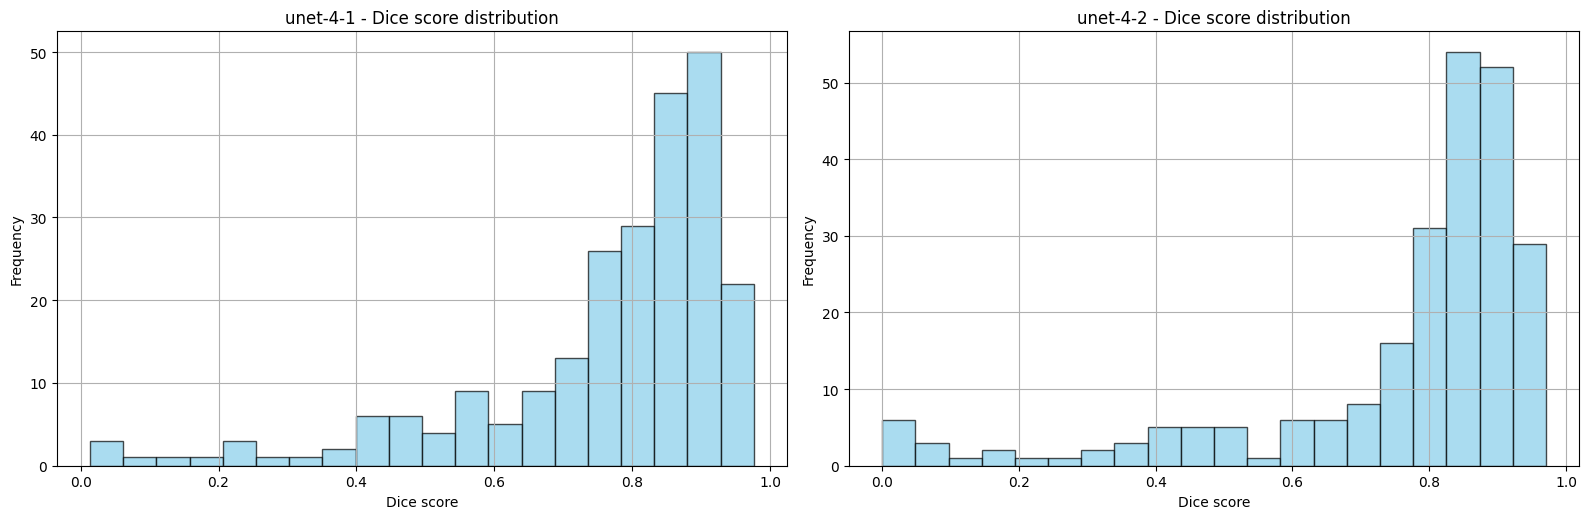

In [11]:
import matplotlib.pyplot as plt

# Set up the 2x2 subplot grid
fig, axs = plt.subplots(1, 2, figsize=(16, 5.3))
axs = axs.flatten()

# Plot histograms for the first 4 models
for i in range(2):
    res = results_unet4[i]
    ax = axs[i]
    
    ax.hist(res['test_dice_scores'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax.set_title(f"{res['name']} - Dice score distribution")
    ax.set_xlabel("Dice score")
    ax.set_ylabel("Frequency")
    ax.grid(True)

plt.tight_layout()
plt.savefig("../outputs/generated_figures/unet4_dice_dist.png", dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# Build a list of dictionaries with desired summary information
summary_data = []

for res in results_unet4:
    summary_data.append({
        "Name": res["name"],
        "Lear. rate": res["lr"],  # Adjust if you stored learning rate elsewhere
        "Depth": res["params"].get("depth"),
        "Channel nr.": res["params"].get("base_channel_size"),
        "Epochs": res["epoch_nr"],
        "Million parameters": to_4_significant_digits(res["number_of_params"]/1000000),
        "Started from": res["started_from"]
    })

# Create DataFrame
summary_df = pd.DataFrame(summary_data)
generate_latex_table_thesis(summary_df, '../outputs/tables/unet4_summary.tex')
# Display the DataFrame
print(summary_df)

       Name Lear. rate  Depth  Channel nr.  Epochs Million parameters  \
0  unet-4-1       1e-2      5           32     100              7.766   
1  unet-4-2       2e-4      5           32     300              7.766   

  Started from  
0         none  
1       unet-4  


In [13]:
# Prepare summary data
summary_data = []

for res in results_unet4:
    # Compute training time in hours
    total_seconds = sum(res.get("epoch_durations", []))
    training_time_hours = round(total_seconds / 3600, 3)

    # Build the row dictionary
    summary_data.append({
        "Name": res["name"],
        "Average Dice index": round(res["test_avg_dice"], 3),
        "Training time [hours]": training_time_hours
    })

# Create DataFrame
summary_df = pd.DataFrame(summary_data)
generate_latex_table_thesis(summary_df, '../outputs/tables/unet4_results.tex')
# Display the result
print(summary_df)

       Name  Average Dice index  Training time [hours]
0  unet-4-1               0.765                  1.783
1  unet-4-2               0.762                  7.590


In [ ]:
import numpy as np
import torch
from tqdm import tqdm

# List of model subdirectories
path_list = ['unet_4_noshuflle']
learning_rates = [ "1e-3"]
started_from_models = [ "none"]
names = [ "unet-4-3"]
epochs = [100]
#path_list = ['unet_6']

# Corresponding model parameter sets
param_sets = [
    {'img_channels': 3, 'mask_channels': 1, 'base_channel_size': 32, 'depth': 5}
]

# A list to store all evaluation results for later processing
results_noshuffle = []

# Iterate through all models and evaluate
for idx, (param, path) in enumerate(zip(param_sets, path_list), 1):
    print(f"\nProcessing model: {idx}/{len(path_list)} ({path})")

    # Initialize model and loss function
    model = UNet(**param)
    loss_fn = DiceLoss()

    # Load model training statistics
    model_dir = f'../saved_models/{path}'
    dice_idcs = list(np.load(f'{model_dir}/dice_idcs.npy'))
    epoch_dice_idcs = list(np.load(f'{model_dir}/epoch_dice_idcs.npy'))
    val_dice_idcs = list(np.load(f'{model_dir}/val_dice_idcs.npy'))
    train_loss = list(np.load(f'{model_dir}/train_loss.npy'))
    val_loss = list(np.load(f'{model_dir}/val_loss.npy'))
    epoch_durations = list(np.load(f'{model_dir}/epoch_durations.npy'))

    # Load best weights
    model.load_state_dict(torch.load(f'{model_dir}/best_model_wts.pth', weights_only=True))
    model.eval().cuda()

    # Evaluate on test set
    avg_score, score_list, preds = evaluate_dice_index(model, test_dataset)

    # Store everything in a dictionary
    result_entry = {
        "name": names[idx-1],
        "params": param,
        "dice_idcs": dice_idcs,
        "epoch_dice_idcs": epoch_dice_idcs,
        "val_dice_idcs": val_dice_idcs,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "epoch_durations" :epoch_durations,
        "test_avg_dice": avg_score,
        "test_dice_scores": score_list,
        "test_predictions": preds,
        "number_of_params": count_trainable_parameters(model),
        "epoch_nr": epochs[idx-1],
        "lr": learning_rates[idx-1],
        "started_from": started_from_models[idx-1]
    }

    # Append results
    results_noshuffle.append(result_entry)

print("\nAll models processed.")



Processing model: 1/1 (unet_4_noshuflle)

All models processed.


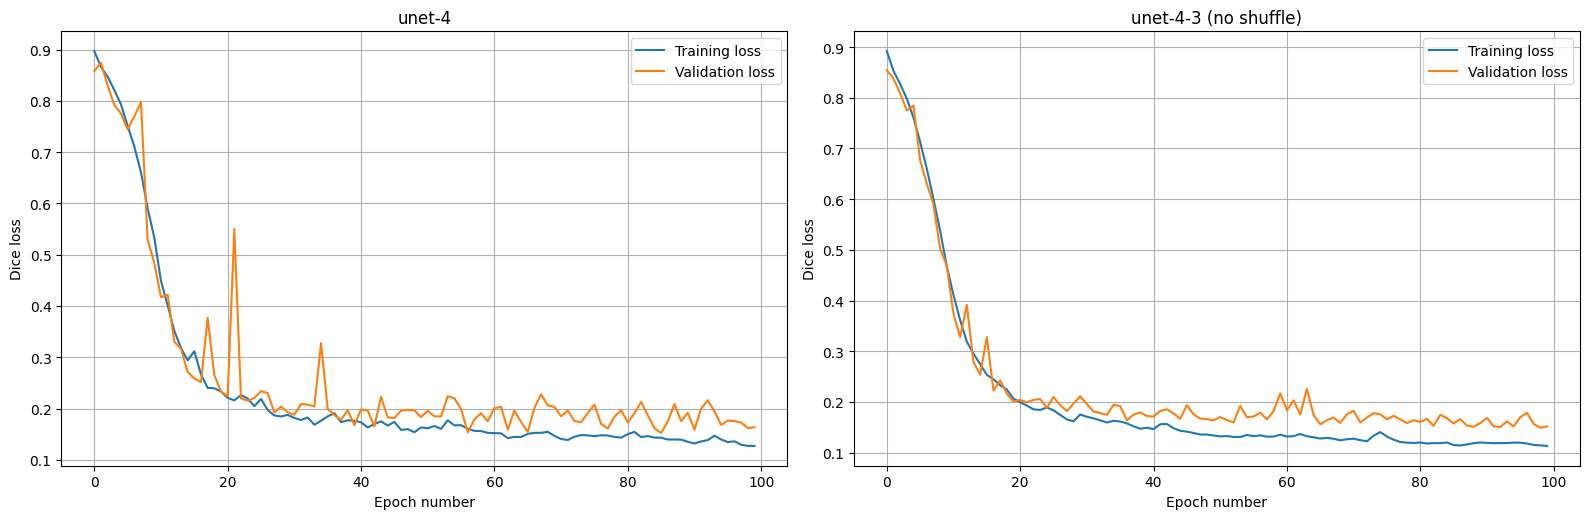

In [ ]:
# Set up the subplot grid
fig, axs = plt.subplots(1, 2, figsize=(16, 5.3))
axs = axs.flatten()  # Flatten the 2D grid into 1D for easier indexing

# Plot each model's loss curves
ax = axs[0]
    
    # Plot training and validation loss
ax.plot(results[4]["train_loss"], label='Training loss')
ax.plot(results[4]["val_loss"], label='Validation loss')
    
ax.set_title(results[4]["name"])
ax.set_xlabel("Epoch number")
ax.set_ylabel("Dice loss")
ax.grid(True)
ax.legend()

ax = axs[1]
    
# Plot training and validation loss
ax.plot(results_noshuffle[0]["train_loss"], label='Training loss')
ax.plot(results_noshuffle[0]["val_loss"], label='Validation loss')
    
ax.set_title(results_noshuffle[0]["name"] + " (no shuffle)")
ax.set_xlabel("Epoch number")
ax.set_ylabel("Dice loss")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.savefig("../outputs/generated_figures/unet4_noshuffle_losses.png", dpi=300, bbox_inches='tight')
plt.show()

## HW specs

In [16]:
# Define the data
data = [
    ["CPU", "Intel core i7-7820HQ"],
    ["RAM", "32GB"],
    ["GPU", "Nvidia Quadro M2200"]
]

# Create the DataFrame
df = pd.DataFrame(data, columns=["Component", "Specification"])
utils.generate_latex_table_thesis(df, '../outputs/tables/HW_specs.tex')